In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, lag, udf, lit
from pyspark.sql.types import FloatType
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Close the Spark session
# spark.stop()

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("PatentAnalysis").getOrCreate()

# Load patent dataset into a PySpark DataFrame
patent_df = spark.read.csv("patents_data.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/02 19:28:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
patent_df.show()

+------------+--------------------+--------------------+-------------------+--------+
|compu_ticker|               title|            abstract|            pubdate|  appnum|
+------------+--------------------+--------------------+-------------------+--------+
|        GMED|system and method...|a screw tower tha...|2023-08-29 00:00:00|17652774|
|        GMED|surgical object t...|a camera tracking...|2023-08-29 00:00:00|17009841|
|        GMED|expandable fusion...|expandable fusion...|2023-08-29 00:00:00|17506754|
|        INTC|multi-protocol su...|systems and devic...|2023-08-29 00:00:00|16831726|
|        INTC|methods and appar...|methods, apparatu...|2023-08-29 00:00:00|16928837|
|        INTC|memory card with ...|an apparatus is d...|2023-08-29 00:00:00|17856947|
|        INTC|apparatus and met...|an apparatus and ...|2023-08-29 00:00:00|17873668|
|        INTC|technologies for ...|technologies for ...|2023-08-29 00:00:00|17321764|
|        INTC|clock crossing fi...|a synchronizer th..

In [4]:
# Group by the 'compu_ticker' column and aggregate the count
ticker_counts = patent_df.groupBy("compu_ticker").count()

# Sort the counts in descending order
ticker_counts = ticker_counts.orderBy(col("count").desc())

# Take the top 10 rows
top_10_tickers = ticker_counts.limit(10)

# Show the result
top_10_tickers.show()

+------------+-----+
|compu_ticker|count|
+------------+-----+
|         IBM|22837|
|        AAPL|10235|
|        QCOM| 9111|
|        INTC| 8914|
|          MU| 6571|
|        SONY| 6266|
|         HMC| 4437|
|          GE| 4216|
|          BA| 4204|
|         NKE| 3789|
+------------+-----+



23/10/02 19:28:52 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


[*********************100%***********************]  1 of 1 completed


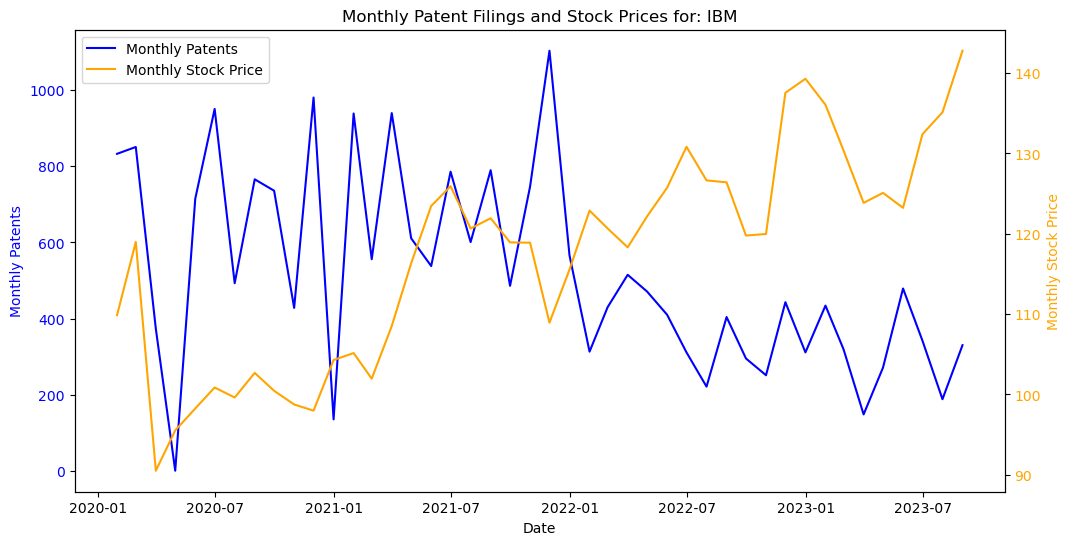

Correlation between Monthly Patents and Stock Prices for IBM:-0.37417213838424773
[*********************100%***********************]  1 of 1 completed


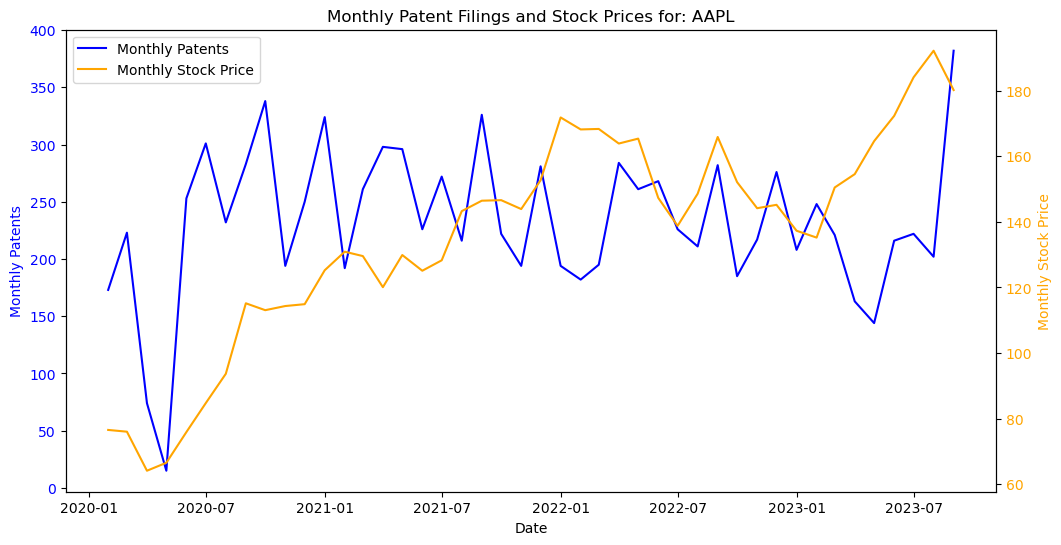

Correlation between Monthly Patents and Stock Prices for AAPL:0.22363720504135173
[*********************100%***********************]  1 of 1 completed


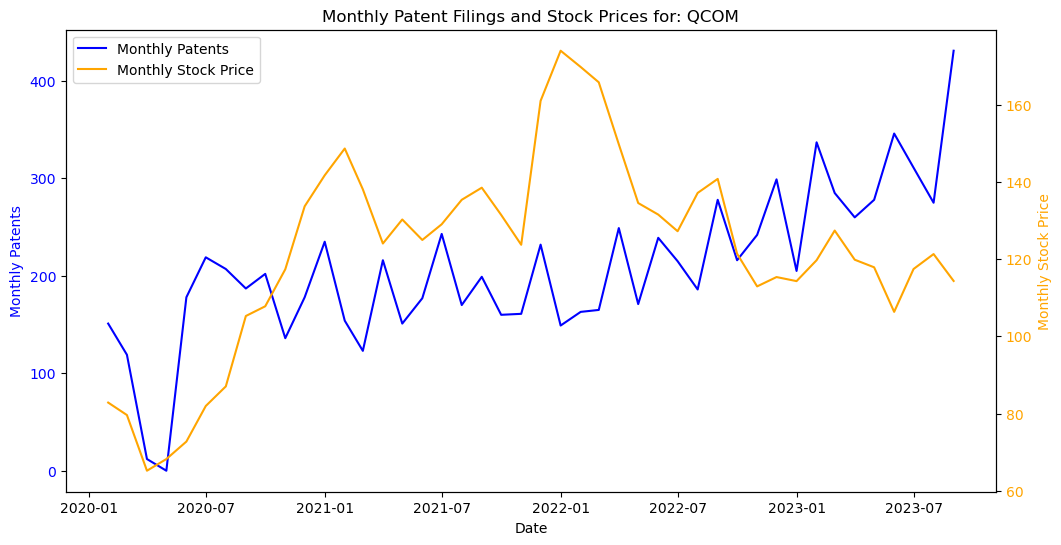

Correlation between Monthly Patents and Stock Prices for QCOM:0.18992349488559382
[*********************100%***********************]  1 of 1 completed


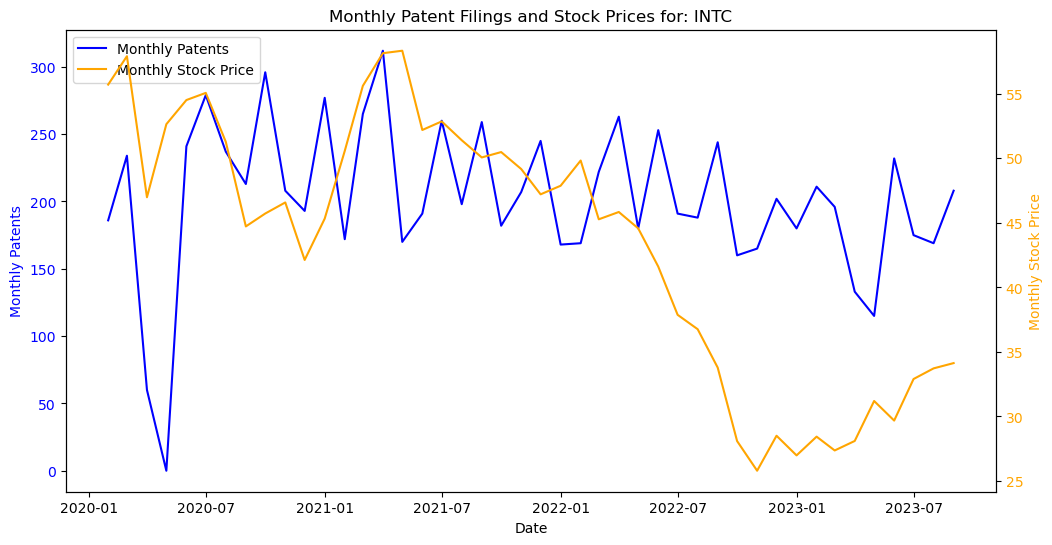

Correlation between Monthly Patents and Stock Prices for INTC:0.2294376491854326
[*********************100%***********************]  1 of 1 completed


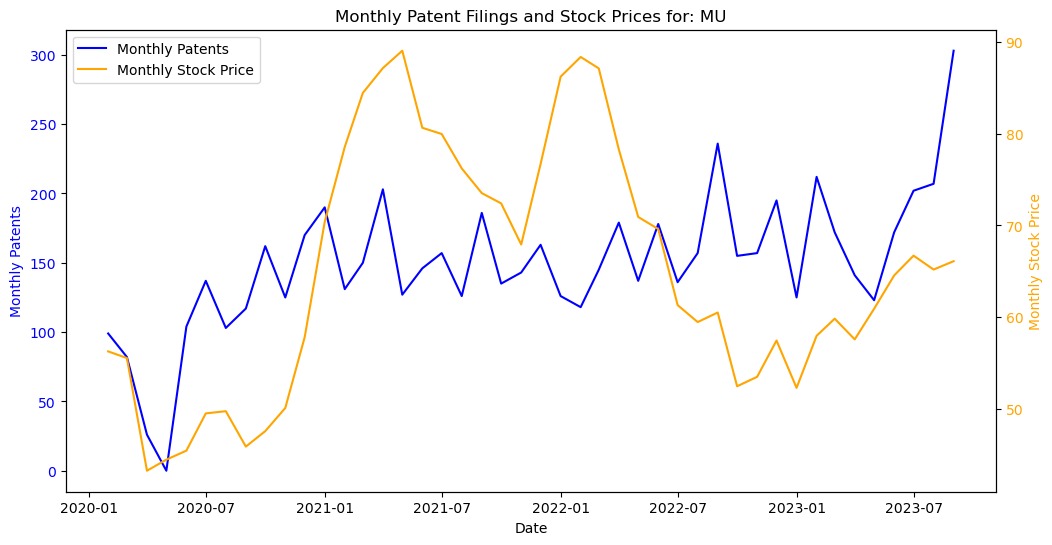

Correlation between Monthly Patents and Stock Prices for MU:0.28950474503507584
[*********************100%***********************]  1 of 1 completed


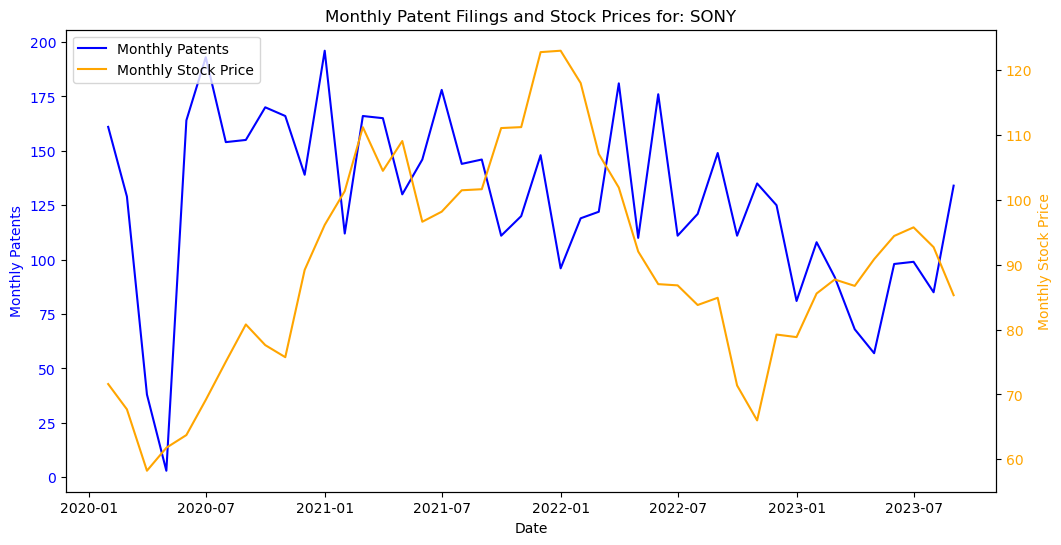

Correlation between Monthly Patents and Stock Prices for SONY:0.13957157227443207
[*********************100%***********************]  1 of 1 completed


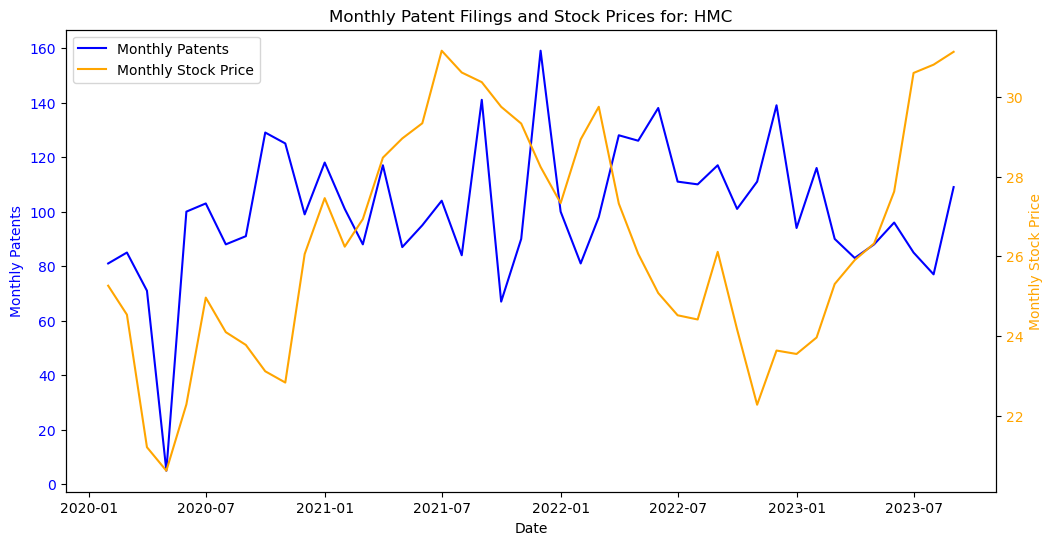

Correlation between Monthly Patents and Stock Prices for HMC:0.09029773028269976
[*********************100%***********************]  1 of 1 completed


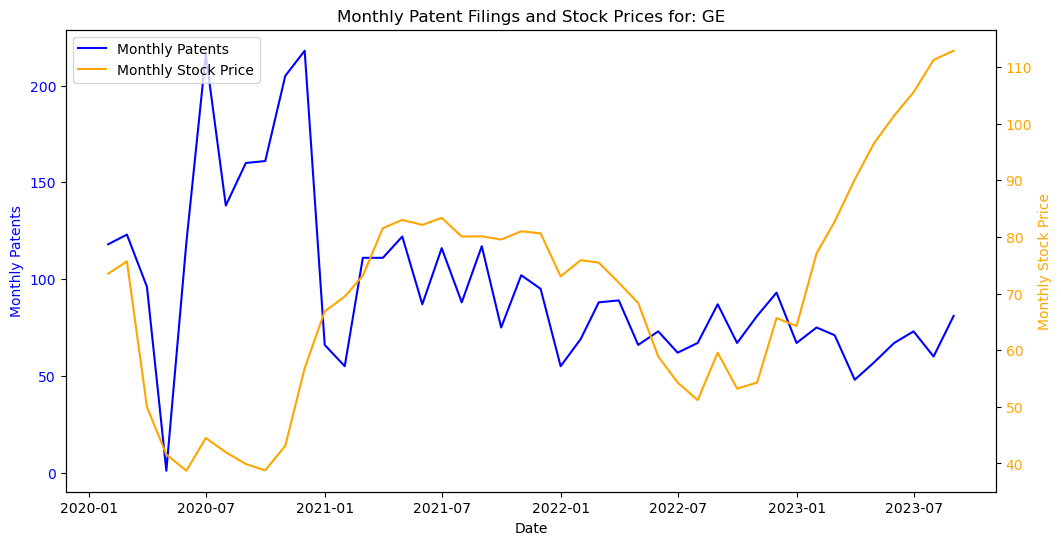

Correlation between Monthly Patents and Stock Prices for GE:-0.3811685627336708
[*********************100%***********************]  1 of 1 completed


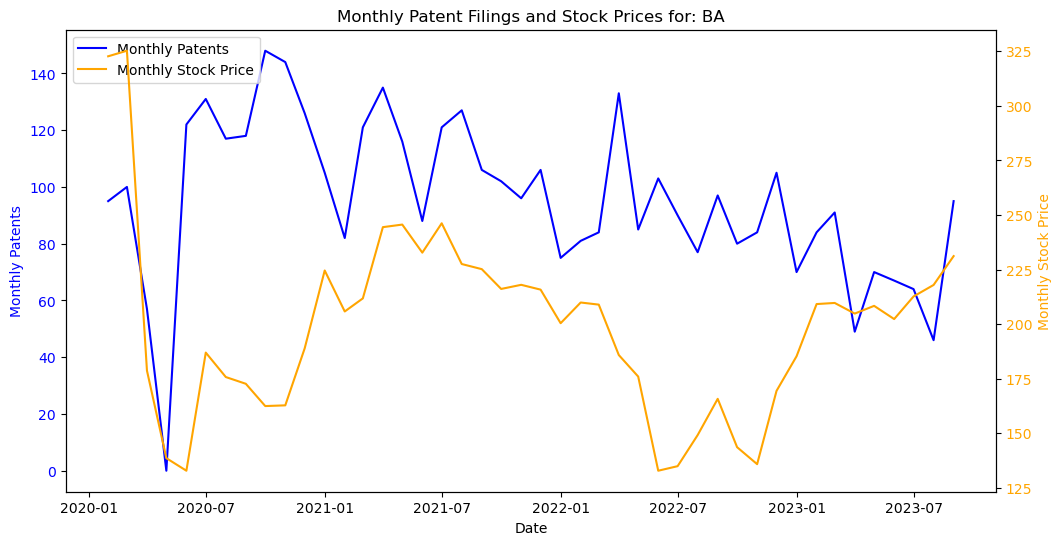

Correlation between Monthly Patents and Stock Prices for BA:0.097502770225944
[*********************100%***********************]  1 of 1 completed


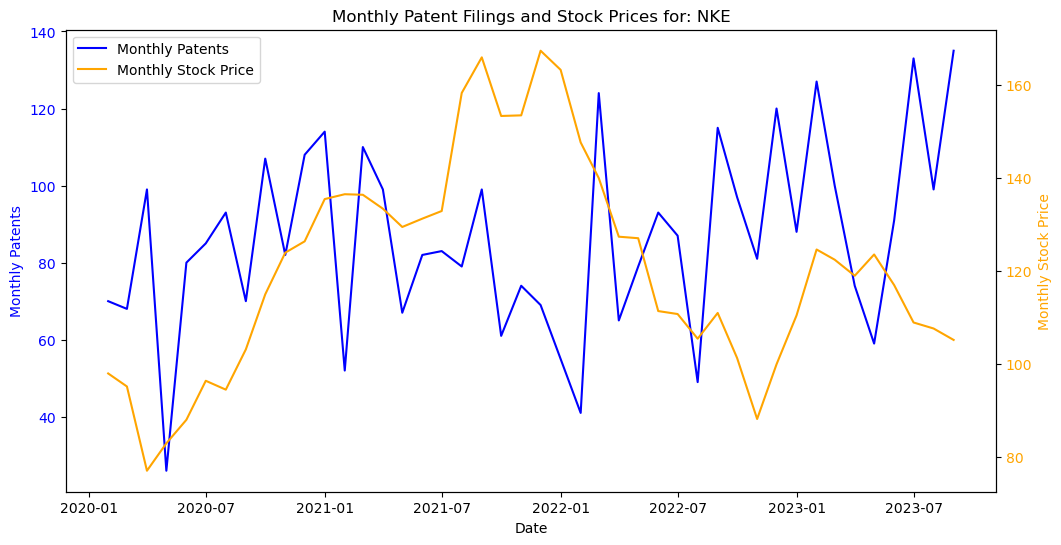

Correlation between Monthly Patents and Stock Prices for NKE:-0.10804862581823967


In [5]:
for row in top_10_tickers.collect():
    
    #Get the ticker from row
    ticker = row['compu_ticker']
    
    # Filter for stock ticker
    ticker_patent_df = patent_df.filter(patent_df.compu_ticker == ticker)

    # Get the minimum and maximum pubdate values for AAPL
    min_pubdate = ticker_patent_df.agg({"pubdate": "min"}).collect()[0]["min(pubdate)"]
    max_pubdate = ticker_patent_df.agg({"pubdate": "max"}).collect()[0]["max(pubdate)"]
    
    # Get historical stock price data for ticker using the minimum and maximum pubdate
    ticker_stock_data = yf.download(ticker, start = min_pubdate.split(' ')[0], end = max_pubdate.split(' ')[0])
    
    # Convert PySpark DataFrame to Pandas DataFrame
    ticker_patent_df = ticker_patent_df.toPandas()

    # Create time series data for patents
    ticker_patent_df['pubdate'] = pd.to_datetime(ticker_patent_df['pubdate'])
    ticker_patent_df.set_index('pubdate', inplace=True)
    
    
    # Resample patent data to monthly frequency
    monthly_patents = ticker_patent_df.resample('M').size()

    # Calculate average stock price on a monthly basis
    monthly_stock_prices = ticker_stock_data['Adj Close'].resample('M').mean()
    
    # Create a figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot monthly patents on the first y-axis
    ax1.plot(monthly_patents.index, monthly_patents.values, label='Monthly Patents', color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Monthly Patents', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis on the right side for stock prices
    ax2 = ax1.twinx()
    ax2.plot(monthly_stock_prices.index, monthly_stock_prices.values, label='Monthly Stock Price', color='orange')
    ax2.set_ylabel('Monthly Stock Price', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc="upper left")

    # Title and show the plot
    plt.title('Monthly Patent Filings and Stock Prices for: ' + ticker)
    plt.show()
    
    # Calculate correlations
    correlation = monthly_patents.corr(monthly_stock_prices)
    print(f'Correlation between Monthly Patents and Stock Prices for ' + ticker + ':' + str(correlation))

In [7]:
# Filter the DataFrame for 'compu_ticker' == 'AAPL' and select the 'pubdate' column
aapl_pubdates = patent_df.filter(col("compu_ticker") == "AAPL").select("pubdate")

# Get unique pubdate values
unique_aapl_pubdates = aapl_pubdates.distinct()

# Sort the unique pubdate values in ascending order
sorted_aapl_pubdates = unique_aapl_pubdates.orderBy("pubdate")

# Show the sorted pubdate values
sorted_aapl_pubdates.show()

+-------------------+
|            pubdate|
+-------------------+
|               NULL|
|2020-01-07 00:00:00|
|2020-01-14 00:00:00|
|2020-01-21 00:00:00|
|2020-01-28 00:00:00|
|2020-02-04 00:00:00|
|2020-02-11 00:00:00|
|2020-02-18 00:00:00|
|2020-02-25 00:00:00|
|2020-03-03 00:00:00|
|2020-03-10 00:00:00|
|2020-03-17 00:00:00|
|2020-03-24 00:00:00|
|2020-03-31 00:00:00|
|2020-04-07 00:00:00|
|2020-04-14 00:00:00|
|2020-05-05 00:00:00|
|2020-05-12 00:00:00|
|2020-05-19 00:00:00|
|2020-05-26 00:00:00|
+-------------------+
only showing top 20 rows

